In [ ]:
tr_path = 'otatrain.csv'  # path to training data

!gdown --id '1c9OkEgKqH0Fx57j37s03uoi4Q_CVYvir' --output otatrain.csv

Downloading...
From: https://drive.google.com/uc?id=1c9OkEgKqH0Fx57j37s03uoi4Q_CVYvir
To: /content/otatrain.csv
2.68MB [00:00, 84.0MB/s]


In [ ]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 13258
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 200.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

## 修改畫圖工具
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [ ]:
class PatchOTA(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 input_array,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        data = np.array(input_array[0:])[:, 0:].astype(float)
        
        if not target_only:
            feats = list(range(2))
        else:
            pass
        if mode == 'test':
            # Testing data
            data = data[:, feats]
            print(data)
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, 2:]
            data = data[:, feats]
            print(data)
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 50 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 50 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 0:] = \
            (self.data[:, 0:] - self.data[:, 0:].mean(dim=0, keepdim=True)) \
            / self.data[:, 0:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of OTA Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [ ]:
with open('otatrain.csv', 'r') as fp:
    data = list(csv.reader(fp))
    horizontal_data = np.array(data[2:4516])[:, 2:]
    vertical_data = np.array(data[4518:9032])[:, 2:]
    total_data = np.array(data[9034:13548])[:, 2:]

In [ ]:
horizontal_dataset = []
for j in range(301):
    for k in range(13):
        ls = []
        ls.append(4000+10*j)
        for element in horizontal_data[1+15*j+k][0:]:
            ls.append(float(element))
        horizontal_dataset.append(ls)

In [ ]:
vertical_dataset = []
for j in range(301):
    for k in range(13):
        ls = []
        ls.append(4000+10*j)
        for element in vertical_data[1+15*j+k][0:]:
            ls.append(float(element))
        vertical_dataset.append(ls)

In [ ]:
total_dataset = []
for j in range(301):
    for k in range(13):
        ls = []
        ls.append(4000+10*j)
        for element in total_data[1+15*j+k][0:]:
            ls.append(float(element))
        total_dataset.append(ls)

In [ ]:
def prep_dataloader(input_array, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = PatchOTA(input_array, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [ ]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()              # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.6f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [ ]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            print('pred = ', pred)
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [ ]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                 

config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 20,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [ ]:
tr_set = prep_dataloader(horizontal_dataset, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(horizontal_dataset, 'dev', config['batch_size'], target_only=target_only)

[[4000.    0.]
 [4000.   15.]
 [4000.   30.]
 ...
 [7000.  150.]
 [7000.  165.]
 [7000.  180.]]
Finished reading the train set of OTA Dataset (3834 samples found, each dim = 2)
[[4000.    0.]
 [4000.   15.]
 [4000.   30.]
 ...
 [7000.  150.]
 [7000.  165.]
 [7000.  180.]]
Finished reading the dev set of OTA Dataset (79 samples found, each dim = 2)


In [ ]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 90),
            nn.RReLU(),
            nn.Linear(90, 25)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

In [ ]:
model = NeuralNet(tr_set.dataset.dim).to(device)

In [ ]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

串流輸出內容已截斷至最後 5000 行。
         -11.2461,  -6.6615,  -4.6378,  -4.9402,  -4.6321,  -4.4975,  -4.4075,
          -3.8631,  -3.6361,  -3.6221,  -6.2021,  -6.1499, -11.5812,  -8.3292,
          -6.8615,  -8.1296,  -6.8339,  -4.8001],
        [ -4.7655,  -6.1658,  -7.6622,  -9.0044, -13.9718, -17.3640, -18.8930,
         -12.5116,  -7.8595,  -5.8696,  -5.0661,  -4.3883,  -3.5778,  -3.9381,
          -4.7514,  -5.4017,  -7.7698, -12.3310, -20.0255, -15.1253, -10.6672,
          -9.0528,  -8.7396,  -6.6299,  -4.7669],
        [-30.4130, -31.1496, -32.4315, -32.7039, -33.2861, -35.7719, -36.8290,
         -39.0037, -37.3404, -33.3053, -32.1020, -30.0566, -31.0685, -31.2063,
         -32.2459, -33.8694, -33.1337, -33.5488, -35.7590, -40.9282, -39.3140,
         -33.8681, -31.3576, -30.6431, -30.4181],
        [-26.2038, -23.6607, -24.5031, -26.9534, -24.1361, -26.7073, -31.4443,
         -33.2124, -29.8802, -25.9666, -24.3041, -24.2477, -22.9787, -21.5239,
         -21.6329, -23.7152, -26.3835, 

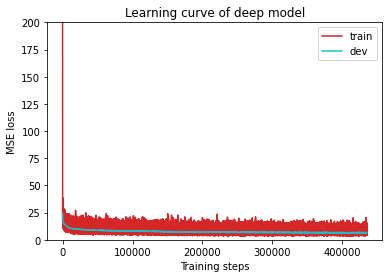

In [ ]:
plot_learning_curve(model_loss_record, title='deep model')

In [373]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds[0]

In [374]:
len(test(dv_set, model, device))

25

In [375]:
ls = []
ls.append([4007.5,8.5])
for ele in horizontal_dataset:
    ls.append(ele[0:2])

In [376]:
len(ls[1])

2

In [377]:
new_set = prep_dataloader(ls, 'test', config['batch_size'], target_only=target_only)

[[4007.5    8.5]
 [4000.     0. ]
 [4000.    15. ]
 ...
 [7000.   150. ]
 [7000.   165. ]
 [7000.   180. ]]
Finished reading the test set of OTA Dataset (3914 samples found, each dim = 2)


In [378]:
a = test(new_set, model, device)

In [379]:
len(test(new_set, model, device))

25

In [380]:
a

array([-16.708418, -17.20657 , -17.716627, -18.567097, -19.972713,
       -22.033005, -27.461767, -31.252625, -26.627018, -22.027365,
       -19.926043, -18.753487, -17.96751 , -17.581512, -17.95506 ,
       -19.931383, -22.708233, -24.60399 , -30.335146, -31.7148  ,
       -27.641083, -21.881584, -18.455532, -18.273169, -16.711952],
      dtype=float32)

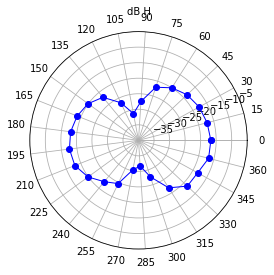

In [385]:
labels = np.array([str(15*j) for j in range(25)])
#資料個數
dataLenth = 25
#資料
data = np.array(a)
#========自己設定結束============

angles = np.linspace(0, 2*np.pi, dataLenth, endpoint=False)
data = np.concatenate((data, [data[0]])) # 閉合 # #將資料結合起來
angles = np.concatenate((angles, [angles[0]])) # 閉合

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, data, 'bo-', linewidth=1)# 畫線四個引數為x,y,標記和顏色，閒的寬度
ax.fill(angles, data, facecolor='r', alpha = 0)# 填充顏色和透明度
ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
ax.set_title("dB H", va='baseline', fontproperties="SimHei")
ax.set_rlim(-40,-5)
ax.grid(True)

plt.show()